In [112]:
#Import the required libraries
import numpy as np 
import pandas as pd 
import seaborn as sns
import pmdarima as pm
import tensorflow as tf
from itertools import product
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
#Load the dataset into a Pandas DataFrame
df = pd.read_csv('Dataset_Uber Traffic.csv')

In [3]:
#Display the first few rows of the dataset
print(df.head())

           DateTime  Junction  Vehicles           ID
0  01/11/2015 00:00         1        15  20151101001
1  01/11/2015 01:00         1        13  20151101011
2  01/11/2015 02:00         1        10  20151101021
3  01/11/2015 03:00         1         7  20151101031
4  01/11/2015 04:00         1         9  20151101041


In [4]:
#Summary statistics
print(df.describe())

           Junction      Vehicles            ID
count  48120.000000  48120.000000  4.812000e+04
mean       2.180549     22.791334  2.016330e+10
std        0.966955     20.750063  5.944854e+06
min        1.000000      1.000000  2.015110e+10
25%        1.000000      9.000000  2.016042e+10
50%        2.000000     15.000000  2.016093e+10
75%        3.000000     29.000000  2.017023e+10
max        4.000000    180.000000  2.017063e+10


In [5]:
#Information about the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB
None


In [6]:
#Check for missing values
print(df.isnull().sum())

DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64


In [7]:
#Since there are no missing values,we move forward with the Aggregating & Preprocessing of data.

In [9]:
#Now we compile traffic data into hourly intervals for each junction
#Step 1: Convert DateTime column to datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'])

In [10]:
#Step 2: Extract the hour and date from the DateTime column
df['Hour'] = df['DateTime'].dt.hour
df['Date'] = df['DateTime'].dt.date

In [11]:
#Step 3: Calculate the average vehicle count per hour for each junction
average_vehicles_per_hour = df.groupby(['Junction', 'Hour'])['Vehicles'].mean().reset_index()

In [12]:
#Step 4: Find the peak traffic hour for each junction
peak_traffic_hours = average_vehicles_per_hour.loc[average_vehicles_per_hour.groupby('Junction')['Vehicles'].idxmax()]

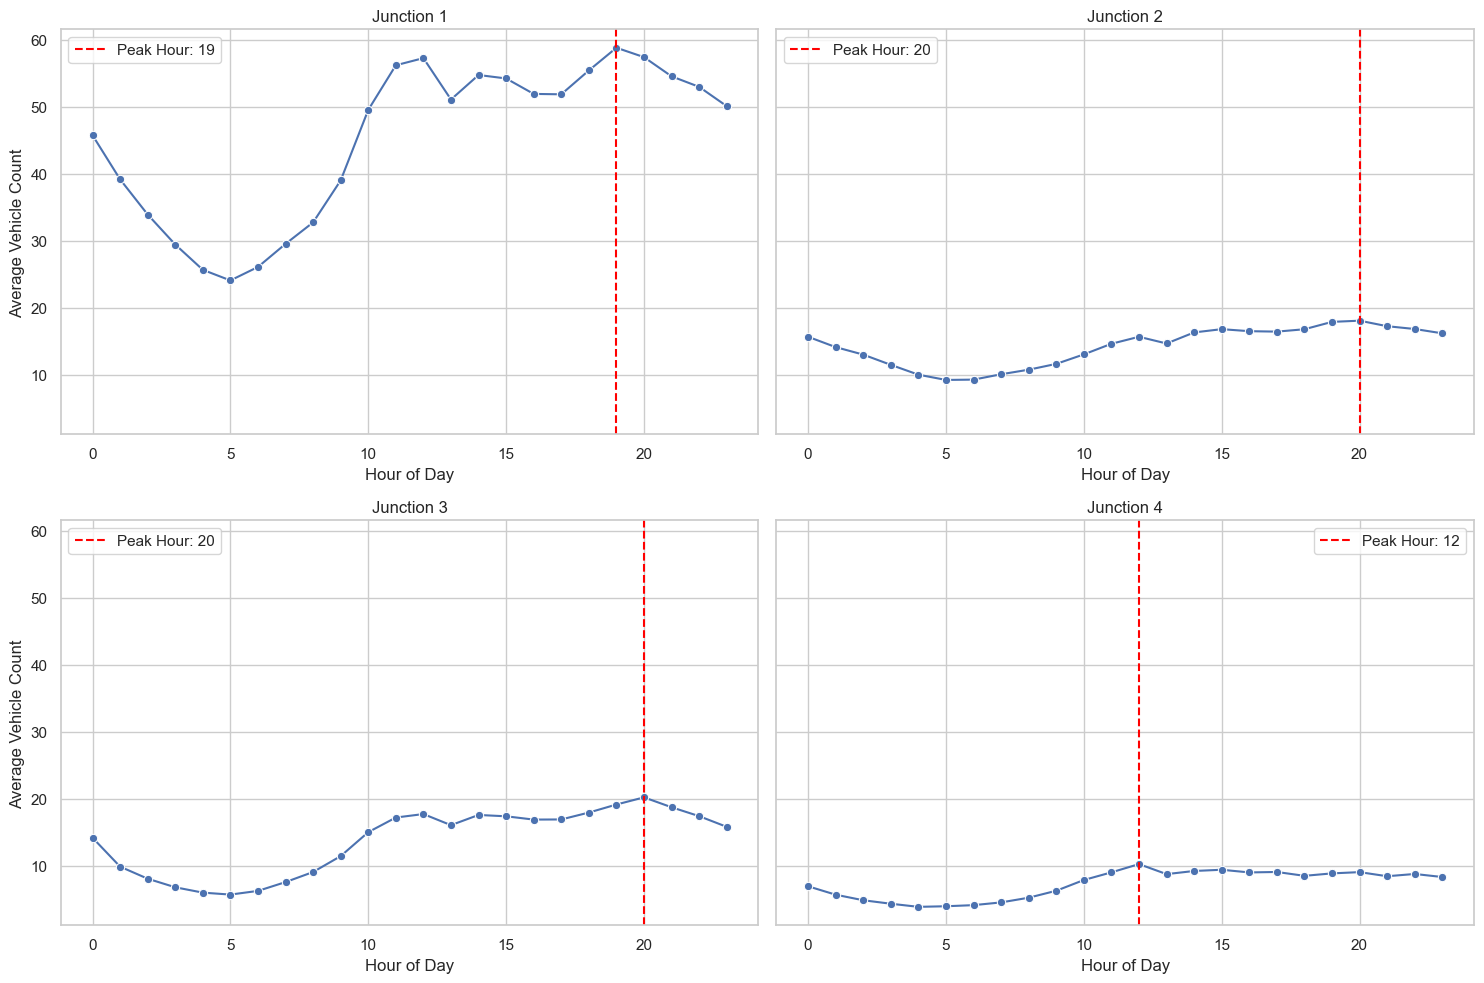

In [15]:
#Step 5: Set up the plotting environment
sns.set(style="whitegrid")

# Step 6: Plot the average vehicle count per hour for each junction
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=True)
junctions = df['Junction'].unique()

for idx, junction in enumerate(junctions):
    ax = axes[idx // 2, idx % 2]
    
    # Filter data for the current junction
    junction_data = average_vehicles_per_hour[average_vehicles_per_hour['Junction'] == junction]
    
    # Plot average vehicle count per hour
    sns.lineplot(x='Hour', y='Vehicles', data=junction_data, ax=ax, marker='o')
    
    # Highlight peak hour with a red dashed line
    peak_hour = peak_traffic_hours.loc[peak_traffic_hours['Junction'] == junction, 'Hour'].values[0]
    ax.axvline(peak_hour, color='red', linestyle='--', label=f'Peak Hour: {peak_hour}')
    
    # Set plot labels and legend
    ax.set_title(f'Junction {junction}')
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Average Vehicle Count')
    ax.legend()

plt.tight_layout()
plt.show()

In [16]:
#From these plots we can infer that Junction 1 is the busiest at 7pm while Junction 2 is 8pm, 
#Junction 3 is 8pm and Junction 4 is 12pm.

In [17]:
#Ensuring data includes relevant details such as vehicle counts.
#Step 1: Extract the day of the week from the DateTime column
df['DayOfWeek'] = df['DateTime'].dt.dayofweek

In [18]:
#Step 2: Calculate the total vehicle count per day of the week for each junction
total_vehicles_per_day = df.groupby(['Junction', 'DayOfWeek'])['Vehicles'].sum().reset_index()

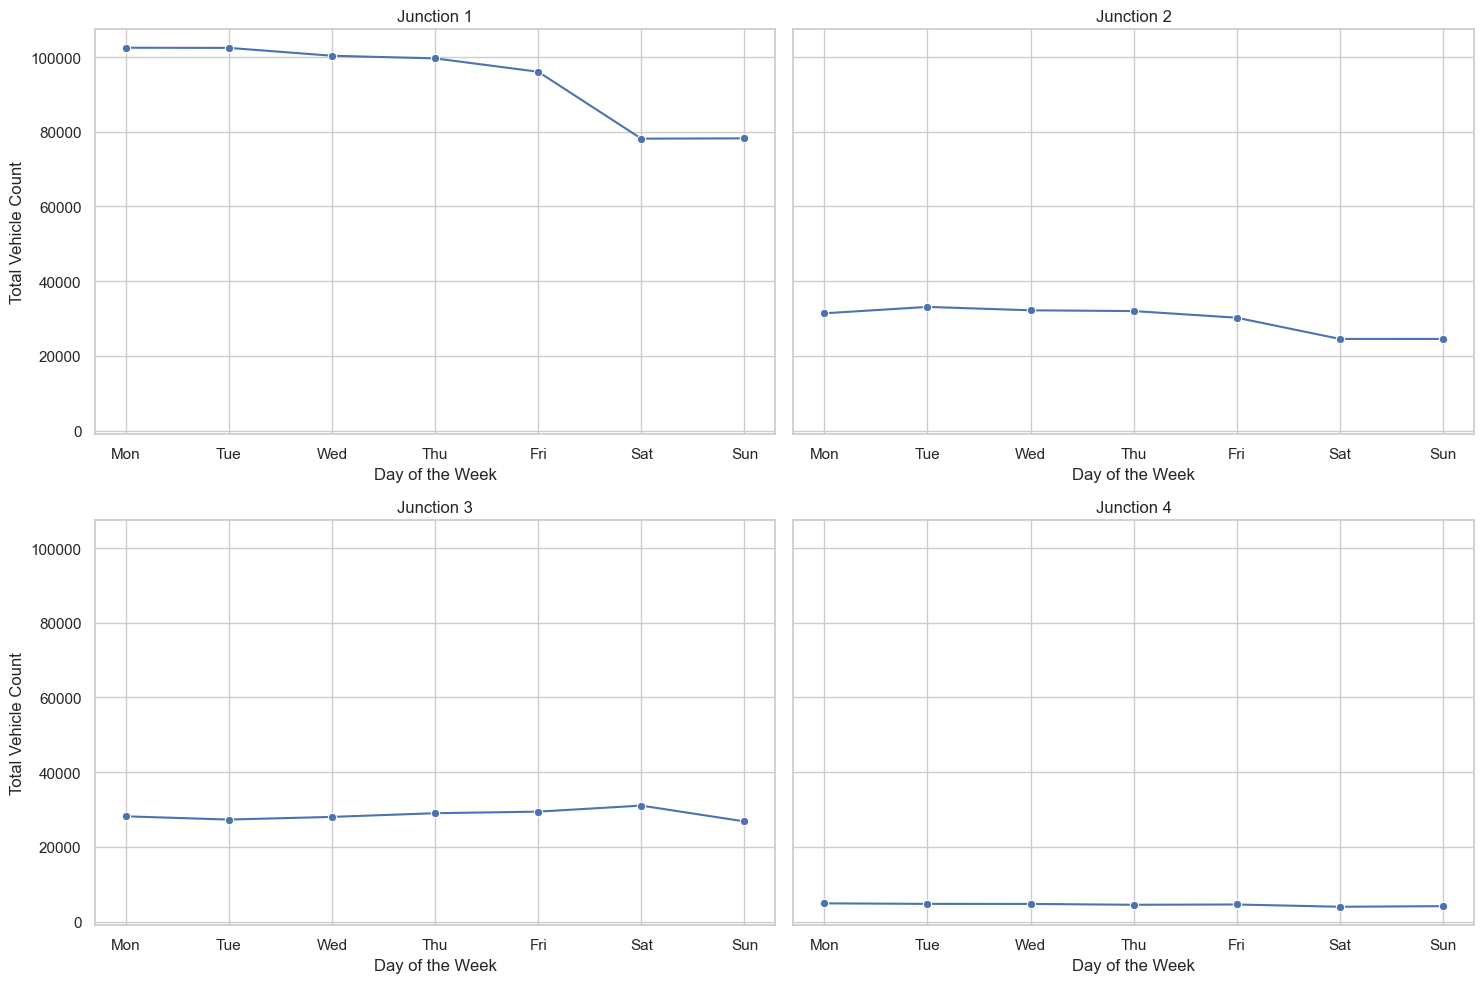

In [19]:
#Step 3: Plot the total vehicle count per day of the week for each junction
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=True)
junctions = df['Junction'].unique()

for idx, junction in enumerate(junctions):
    ax = axes[idx // 2, idx % 2]
    
    # Filter data for the current junction
    junction_data = total_vehicles_per_day[total_vehicles_per_day['Junction'] == junction]
    
    # Plot total vehicle count per day of the week
    sns.lineplot(x='DayOfWeek', y='Vehicles', data=junction_data, ax=ax, marker='o')
    
    # Set plot labels and formatting
    ax.set_title(f'Junction {junction}')
    ax.set_xlabel('Day of the Week')
    ax.set_ylabel('Total Vehicle Count')
    ax.set_xticks(range(7))
    ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

plt.tight_layout()
plt.show()

In [20]:
#Creating binary indicators for weekends (1 for weekends, 0 for weekdays)
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

Text(0.5, 1.0, 'Average Vehicle Counts for Weekdays vs Weekends')

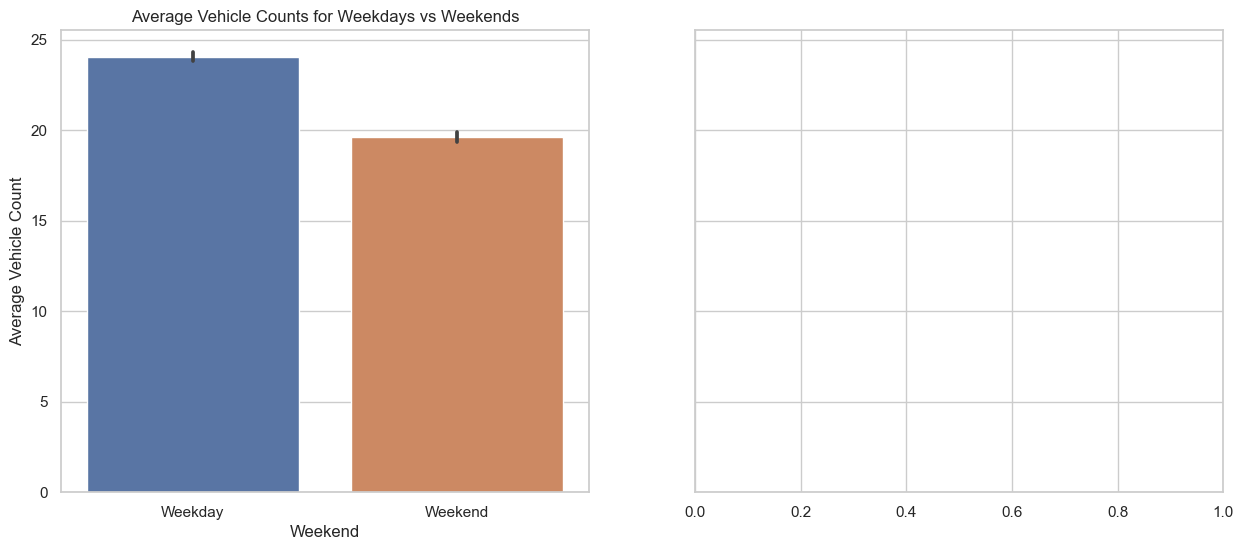

In [30]:
# Step 4: Plot average vehicle counts by weekends and events
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

#Plot 1: Average vehicle counts for weekends vs weekdays
sns.barplot(x='IsWeekend', y='Vehicles', data=df, estimator=np.mean, ax=axes[0])
axes[0].set_xticklabels(['Weekday', 'Weekend'])
axes[0].set_xlabel('Weekend')
axes[0].set_ylabel('Average Vehicle Count')
axes[0].set_title('Average Vehicle Counts for Weekdays vs Weekends')

C:\Users\HP\AppData\Local\Temp\ipykernel_17452\2083230570.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Month', y='Vehicles', hue='Year', data=df, estimator='mean', ci=None)


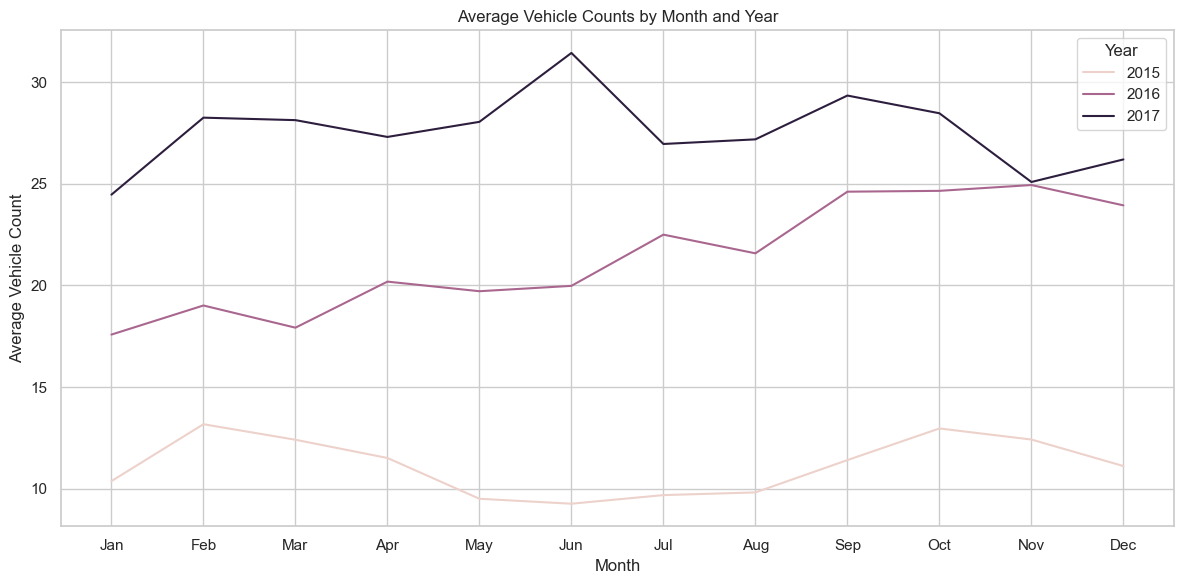

In [32]:
#Plot 2: Plot average vehicle counts by year and month
df['Year'] = df['DateTime'].dt.year
df['Month'] = df['DateTime'].dt.month

plt.figure(figsize=(12, 6))
sns.lineplot(x='Month', y='Vehicles', hue='Year', data=df, estimator='mean', ci=None)
plt.xlabel('Month')
plt.ylabel('Average Vehicle Count')
plt.title('Average Vehicle Counts by Month and Year')
plt.xticks(range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year')

plt.tight_layout()
plt.show()

In [33]:
#Observing this, we see that the average number of vehicles has increased substantially from 2015 to 2017.

C:\Users\HP\AppData\Local\Temp\ipykernel_17452\1107595796.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = df.corr()


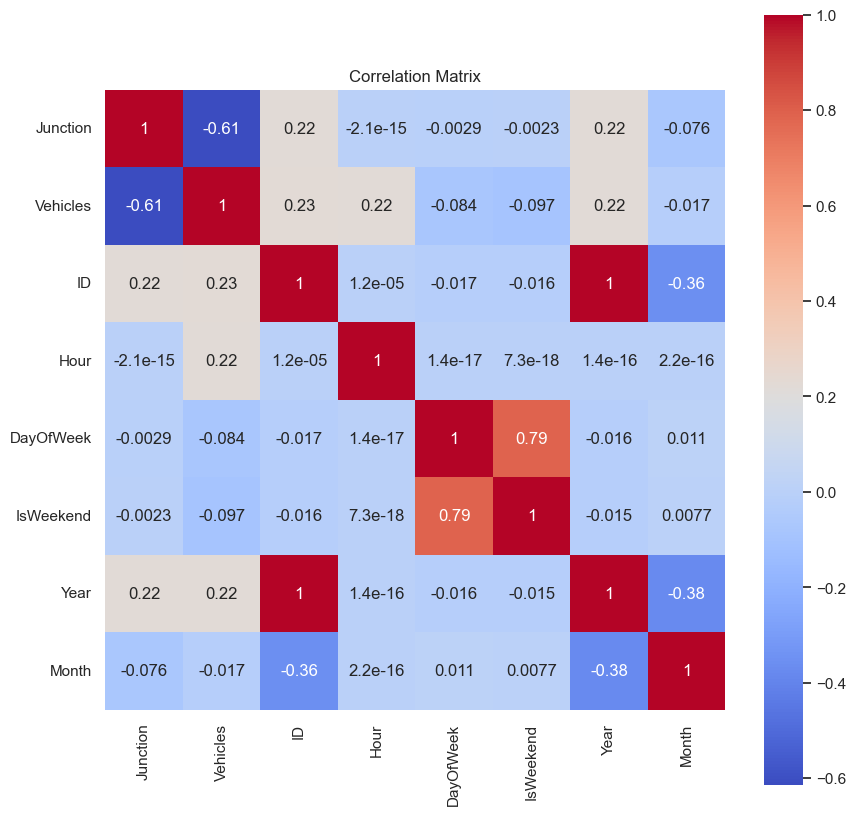

In [35]:
#Plotting the correlation matrix
corrmat = df.corr()

plt.subplots(figsize=(10, 10), facecolor="white") 
sns.heatmap(corrmat, cmap="coolwarm", annot=True, square=True)
plt.title('Correlation Matrix')
plt.show()

In [36]:
#Lastly, to wrap up this observation of our first data set, we will view a pairplot and explore relationships 
#between variables, identify patterns, and gain insights into potential correlations and distributions within your data.

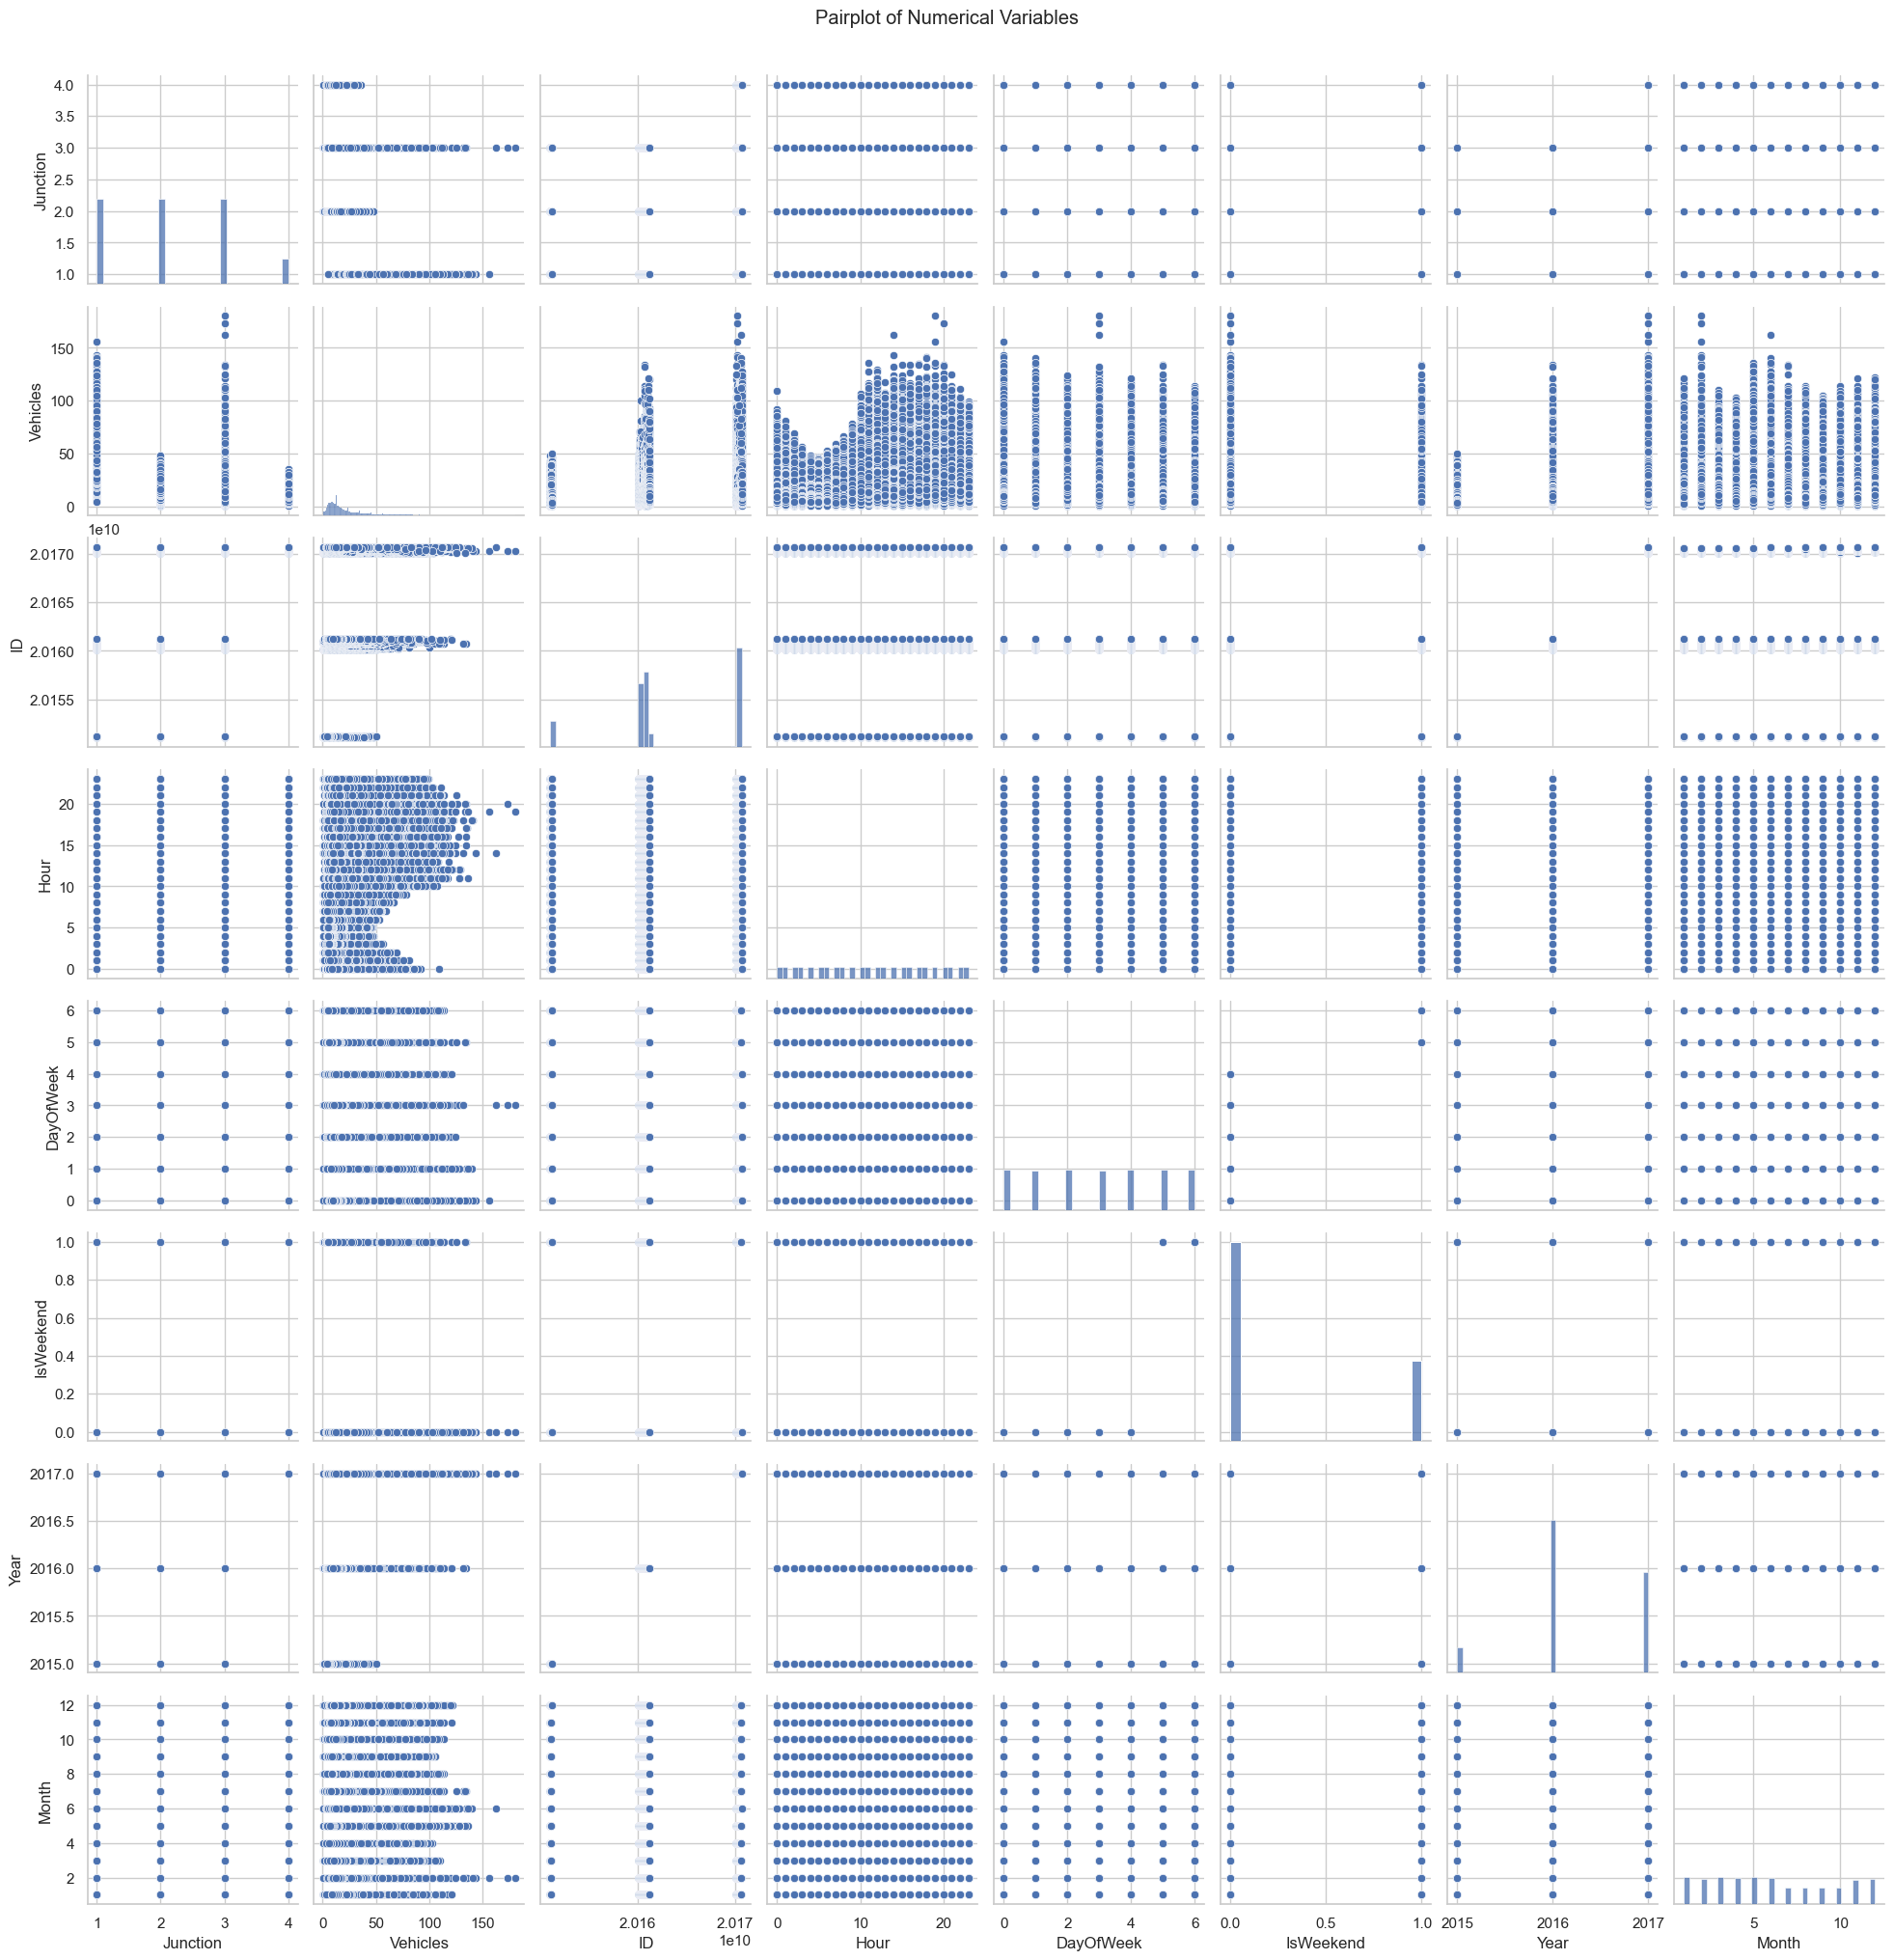

In [39]:
#Create a pairplot
sns.pairplot(df)
plt.suptitle('Pairplot of Numerical Variables', y=1.02)
plt.show()

In [41]:
#Load the other dataset into a Pandas DataFrame
df2 = pd.read_csv('Dataset_WeatherEvent.csv')

In [42]:
#Display the first few rows of the dataset
print(df2.head())

    Event          DateTime  Temperature (°F)  Humidity (%)  Pressure (in)  \
0  Diwali  02/11/2015 00:00                77            65          29.11   
1  Diwali  02/11/2015 01:00                76            66          29.10   
2  Diwali  02/11/2015 02:00                75            66          29.10   
3  Diwali  02/11/2015 03:00                74            67          29.09   
4  Diwali  02/11/2015 04:00                74            67          29.09   

   Wind Speed (mph)  
0                 3  
1                 3  
2                 3  
3                 3  
4                 4  


In [43]:
#Summary statistics
print(df2.describe())

       Temperature (°F)  Humidity (%)  Pressure (in)  Wind Speed (mph)
count        889.000000    889.000000     889.000000        889.000000
mean          85.955006     47.235096      29.104533         13.566929
std           15.731281     19.820474       0.173631          7.559841
min           52.000000     -6.000000      28.620000          0.000000
25%           73.000000     37.000000      28.980000          7.000000
50%           88.000000     52.000000      29.110000         13.000000
75%           99.000000     62.000000      29.240000         20.000000
max          118.000000     88.000000      29.480000         32.000000


In [44]:
#Information about the dataset
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Event             889 non-null    object 
 1   DateTime          889 non-null    object 
 2   Temperature (°F)  889 non-null    int64  
 3   Humidity (%)      889 non-null    int64  
 4   Pressure (in)     889 non-null    float64
 5   Wind Speed (mph)  889 non-null    int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 41.8+ KB
None


In [45]:
#Check for missing values
print(df2.isnull().sum())

Event               0
DateTime            0
Temperature (°F)    0
Humidity (%)        0
Pressure (in)       0
Wind Speed (mph)    0
dtype: int64


In [51]:
#Now we move on to merging the two datasets and then consequentially filling the missing values.
#Firstly, after performing the merge operation I noticed that since the traffic data set is considerably larger than the
#Weather and event one, I wrote a python script that merges traffic data from 'Dataset_Uber Traffic.csv' with weather 
#event data from 'Dataset_WeatherEvent.csv' and outputs the combined data to 'merged_data.csv'. 
#For dates without corresponding weather events, it generates synthetic weather data based on predefined rules. 
#The noevent function creates realistic temperature, humidity, pressure, and wind speed values for these missing entries.

In [68]:
#Load the other dataset into a Pandas DataFrame
df3 = pd.read_csv('merged_data.csv')

#Inspect the columns of the merged DataFrame
print("Columns in the merged DataFrame:")
print(df3.columns)

Columns in the merged DataFrame:
Index(['DateTime', 'Junction', 'Vehicles', 'ID', '﻿Event', 'Temperature (°F)',
       'Humidity (%)', 'Pressure (in)', 'Wind Speed (mph)'],
      dtype='object')


In [69]:
#Data Preprocessing and Feature Engineering
#Convert 'DateTime' column to datetime format
df3['DateTime'] = pd.to_datetime(df3['DateTime'])

#Extract 'Hour' from 'DateTime'
df3['Hour'] = df3['DateTime'].dt.hour

#Extract 'DayOfWeek' from 'DateTime'
df3['DayOfWeek'] = df3['DateTime'].dt.dayofweek

#Create 'IsWeekend' binary indicator (1 if weekend, 0 otherwise)
df3['IsWeekend'] = df3['DayOfWeek'].isin([5, 6]).astype(int)

# Rename the event column if it has a hidden character or whitespace
df3.rename(columns={'﻿Event': 'Event'}, inplace=True)

# Create 'IsEvent' binary indicator (1 if event, 0 if no event)
df3['IsEvent'] = df3['Event'].apply(lambda x: 0 if x.strip() == 'NoEvent' else 1)

#Inspect the modified DataFrame
print(df3.head())

             DateTime  Junction  Vehicles           ID    Event  \
0 2015-01-11 00:00:00         1        15  20151101001  NoEvent   
1 2015-01-11 01:00:00         1        13  20151101011  NoEvent   
2 2015-01-11 02:00:00         1        10  20151101021  NoEvent   
3 2015-01-11 03:00:00         1         7  20151101031  NoEvent   
4 2015-01-11 04:00:00         1         9  20151101041  NoEvent   

   Temperature (°F)  Humidity (%)  Pressure (in)  Wind Speed (mph)  Hour  \
0                65            62          29.18                 1     0   
1                63            66          29.16                 2     1   
2                58            72          29.22                 3     2   
3                55            74          29.28                 3     3   
4                54            70          29.28                 3     4   

   DayOfWeek  IsWeekend  IsEvent  
0          6          1        0  
1          6          1        0  
2          6          1        0  


In [70]:
#Now we further observe the dataset
#Summary statistics
print(df3.describe())

           Junction      Vehicles            ID  Temperature (°F)  \
count  48120.000000  48120.000000  4.812000e+04      48120.000000   
mean       2.180549     22.791334  2.016330e+10         60.408001   
std        0.966955     20.750063  5.944854e+06         11.587409   
min        1.000000      1.000000  2.015110e+10         38.000000   
25%        1.000000      9.000000  2.016042e+10         52.000000   
50%        2.000000     15.000000  2.016093e+10         60.000000   
75%        3.000000     29.000000  2.017023e+10         67.000000   
max        4.000000    180.000000  2.017063e+10        114.000000   

       Humidity (%)  Pressure (in)  Wind Speed (mph)          Hour  \
count  48120.000000   48120.000000      48120.000000  48120.000000   
mean      67.296072      29.145563          6.520158     11.500000   
std       26.324547       0.091777          4.284973      6.922258   
min       -6.000000      28.780000          0.000000      0.000000   
25%       46.000000      29.

In [71]:
#Information about the dataset
print(df3.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DateTime          48120 non-null  datetime64[ns]
 1   Junction          48120 non-null  int64         
 2   Vehicles          48120 non-null  int64         
 3   ID                48120 non-null  int64         
 4   Event             48120 non-null  object        
 5   Temperature (°F)  48120 non-null  int64         
 6   Humidity (%)      48120 non-null  int64         
 7   Pressure (in)     48120 non-null  float64       
 8   Wind Speed (mph)  48120 non-null  int64         
 9   Hour              48120 non-null  int64         
 10  DayOfWeek         48120 non-null  int64         
 11  IsWeekend         48120 non-null  int32         
 12  IsEvent           48120 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(9), object(1)
memory usage

In [72]:
#Check for missing values
print(df3.isnull().sum())

DateTime            0
Junction            0
Vehicles            0
ID                  0
Event               0
Temperature (°F)    0
Humidity (%)        0
Pressure (in)       0
Wind Speed (mph)    0
Hour                0
DayOfWeek           0
IsWeekend           0
IsEvent             0
dtype: int64


In [73]:
#Save the modified DataFrame to a CSV file
df3.to_csv('modified_merged_data.csv', index=False)

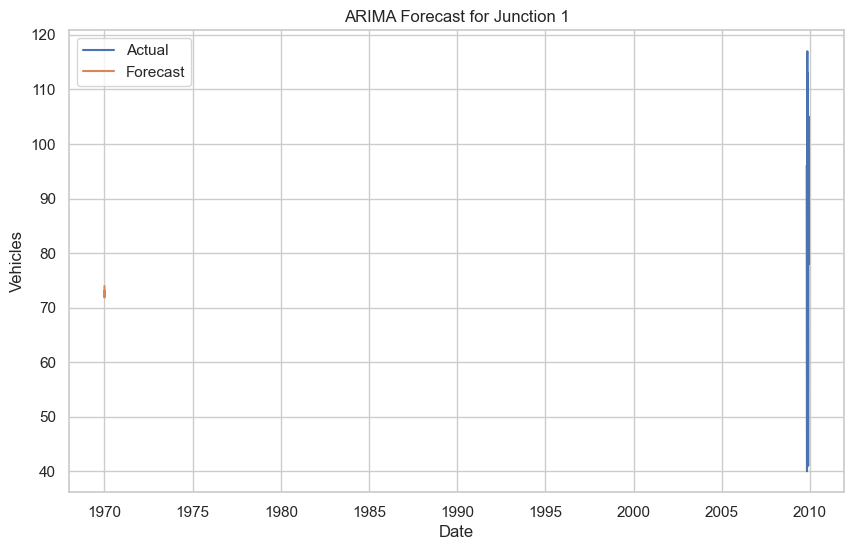

ARIMA RMSE: 5.973951226324065


In [76]:
#Now we'll be doing Model Development and Training
#First, we will consider the ARIMA Model Junction 1 

# Subset data for Junction 1 (example)
df3_junction1 = df3[df3['Junction'] == 1]

#Fit ARIMA model
model = ARIMA(df3_junction1['Vehicles'], order=(5, 1, 0))
model_fit = model.fit()

#Forecast next steps
forecast_steps = 24
forecast = model_fit.forecast(steps=forecast_steps)

#Plotting
plt.figure(figsize=(10, 6))
plt.plot(df3_junction1.index[-50:], df3_junction1['Vehicles'].tail(50), label='Actual')
plt.plot(pd.date_range(start=df3_junction1.index[-1], periods=forecast_steps, freq='H'), forecast, label='Forecast')
plt.title('ARIMA Forecast for Junction 1')
plt.xlabel('Date')
plt.ylabel('Vehicles')
plt.legend()
plt.show()

#Evaluate model performance (example using RMSE)
predictions = model_fit.predict()
rmse = np.sqrt(mean_squared_error(df3_junction1['Vehicles'], predictions))
print(f"ARIMA RMSE: {rmse}")



Epoch 1/50

365/365 [==============================] - 47s 11ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 2/50
365/365 [==============================] - 3s 8ms/step - loss: 0.0018 - val_loss: 0.0041
Epoch 3/50
365/365 [==============================] - 3s 8ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 4/50
365/365 [==============================] - 3s 7ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 5/50
365/365 [==============================] - 3s 8ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 6/50
365/365 [==============================] - 3s 7ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 7/50
365/365 [==============================] - 3s 7ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 8/50
365/365 [==============================] - 2s 7ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 9/50
365/365 [==============================] - 3s 8ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 10/50
365/365 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0

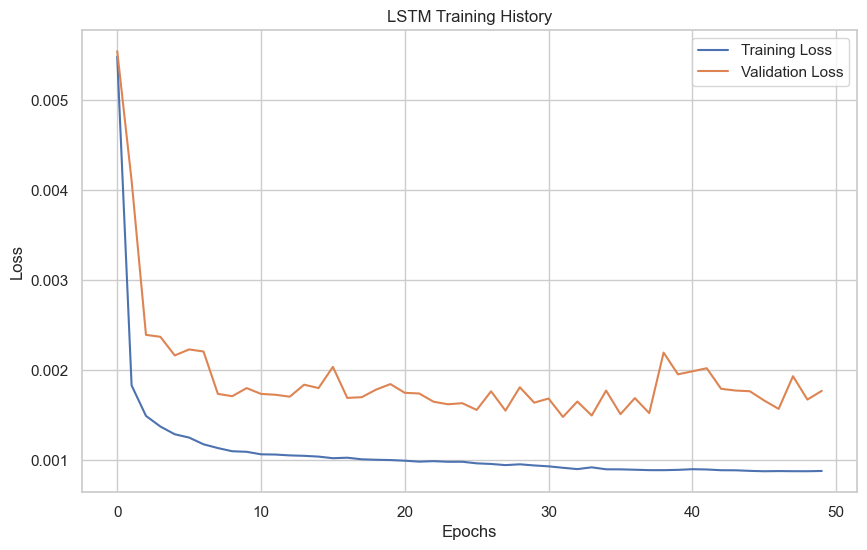

92/92 [==============================] - 3s 3ms/step


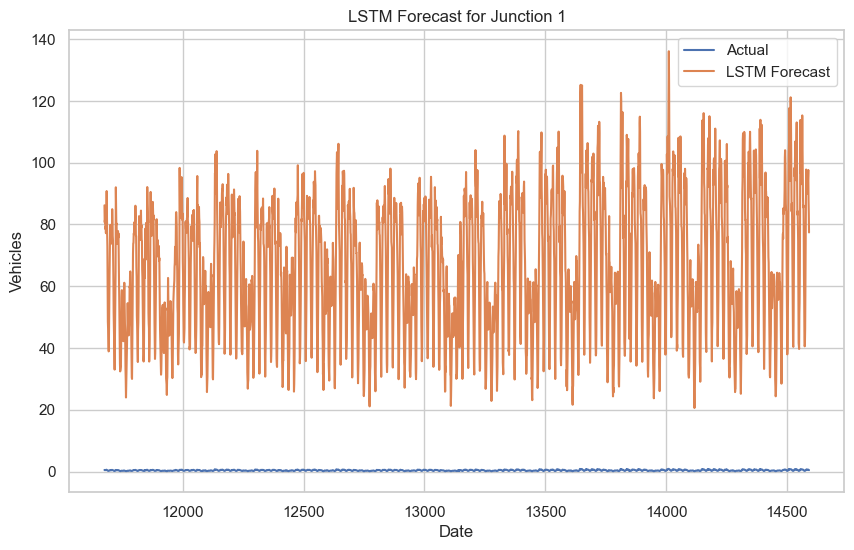

LSTM RMSE: 69.11474603901735


In [77]:
# Subset data for Junction 1 (example)
df3_junction1 = df3[df3['Junction'] == 1]

# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df3_junction1['Vehicles'].values.reshape(-1, 1))

# Prepare data sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Set sequence length and create sequences
sequence_length = 12  # Example sequence length
X, y = create_sequences(scaled_data, sequence_length)

# Split data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define LSTM model architecture
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dense(units=1)
])

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Forecast using trained LSTM model
forecast_lstm = model.predict(X_test)

# Inverse transform to get actual predictions
forecast_lstm = scaler.inverse_transform(forecast_lstm).flatten()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df3_junction1.index[-len(y_test):], y_test, label='Actual')
plt.plot(df3_junction1.index[-len(y_test):], forecast_lstm, label='LSTM Forecast')
plt.title('LSTM Forecast for Junction 1')
plt.xlabel('Date')
plt.ylabel('Vehicles')
plt.legend()
plt.show()

# Evaluate model performance (example using RMSE)
rmse_lstm = np.sqrt(mean_squared_error(y_test, forecast_lstm))
print(f"LSTM RMSE: {rmse_lstm}")


In [79]:
#Results indicate that the ARIMA model performed significantly better than the LSTM model in terms of RMSE 
#for traffic forecasting at Junction 1. LSTM Training History Observation: The training loss decreases steadily while 
#the validation loss stabilizes but shows some fluctuations. This indicates that the model is learning but may be 
#overfitting or not generalizing well on unseen data.

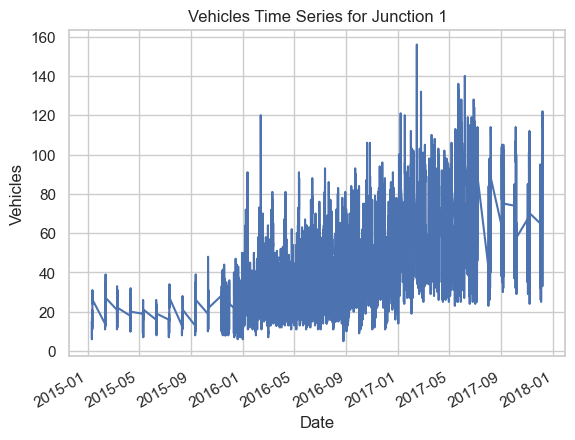

In [80]:
#Fixing the Arima Model
#Ensure DateTime is a datetime object and set it as the index
df3['DateTime'] = pd.to_datetime(df3['DateTime'])
df3.set_index('DateTime', inplace=True)

#Ensure the data is sorted by DateTime
df3 = df3.sort_index()

#Select data for Junction 1
junction_1_data = df3[df3['Junction'] == 1]

#Plot the data to visualize it
junction_1_data['Vehicles'].plot()
plt.title('Vehicles Time Series for Junction 1')
plt.xlabel('Date')
plt.ylabel('Vehicles')
plt.show()

ADF Statistic: -6.817565956498178
p-value: 2.040660217377322e-09


C:\Users\HP\AppData\Local\Temp\ipykernel_17452\3235755757.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  junction_1_data['Vehicles_diff'] = junction_1_data['Vehicles']


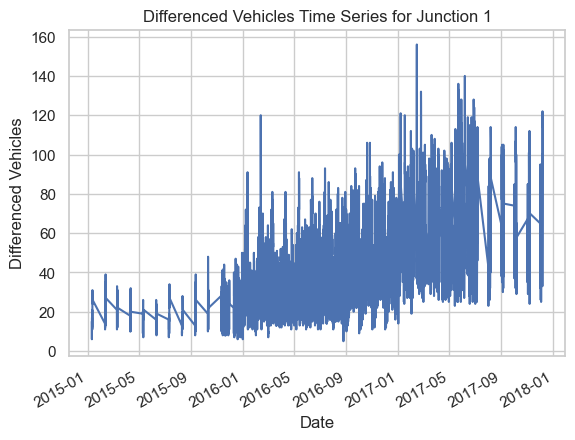

In [84]:
#Step 2: Check for Stationarity and Differencing
# Perform the Augmented Dickey-Fuller test
result = adfuller(junction_1_data['Vehicles'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# If p-value > 0.05, data is non-stationary and needs differencing
if result[1] > 0.05:
    # Perform differencing
    junction_1_data['Vehicles_diff'] = junction_1_data['Vehicles'].diff().dropna()
else:
    junction_1_data['Vehicles_diff'] = junction_1_data['Vehicles']

# Plot differenced data
junction_1_data['Vehicles_diff'].plot()
plt.title('Differenced Vehicles Time Series for Junction 1')
plt.xlabel('Date')
plt.ylabel('Differenced Vehicles')
plt.show()

In [85]:
#Since the p-value from the Augmented Dickey-Fuller (ADF) test is significantly less than 0.05, we can reject the
#null hypothesis that the series has a unit root and conclude that the series is stationary.

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                14592
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -46568.299
Date:                Tue, 09 Jul 2024   AIC                          93148.597
Time:                        22:37:02   BIC                          93194.126
Sample:                             0   HQIC                         93163.724
                              - 14592                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.002      0.195      0.845      -0.003       0.004
ar.L1          1.8926      0.003    640.115      0.000       1.887       1.898
ar.L2         -0.9568      0.003   -350.797      0.0

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:

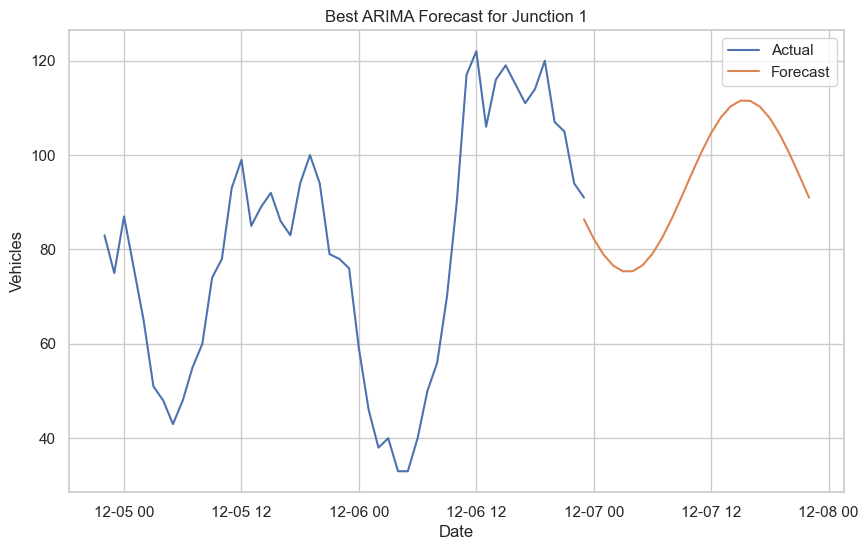

Best ARIMA RMSE: 23.349917699799303


In [86]:
#Step 3: Fit ARIMA Model
#Use auto_arima to find the best parameters
auto_model = pm.auto_arima(junction_1_data['Vehicles'], seasonal=False, stepwise=True, suppress_warnings=True)
print(auto_model.summary())

#Fit the best model
best_model = ARIMA(junction_1_data['Vehicles'], order=auto_model.order)
best_model_fit = best_model.fit()

#Forecast and plot
best_forecast = best_model_fit.forecast(steps=24)
plt.figure(figsize=(10, 6))
plt.plot(junction_1_data.index[-50:], junction_1_data['Vehicles'].iloc[-50:], label='Actual')
plt.plot(pd.date_range(start=junction_1_data.index[-1], periods=24, freq='H'), best_forecast, label='Forecast')
plt.title('Best ARIMA Forecast for Junction 1')
plt.xlabel('Date')
plt.ylabel('Vehicles')
plt.legend()
plt.show()

#Calculate RMSE
best_rmse = np.sqrt(mean_squared_error(junction_1_data['Vehicles'].iloc[-24:], best_forecast))
print('Best ARIMA RMSE:', best_rmse)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                14592
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -46568.299
Date:                Tue, 09 Jul 2024   AIC                          93148.597
Time:                        22:43:09   BIC                          93194.126
Sample:                             0   HQIC                         93163.724
                              - 14592                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.002      0.195      0.845      -0.003       0.004
ar.L1          1.8926      0.003    640.115      0.000       1.887       1.898
ar.L2         -0.9568      0.003   -350.797      0.0

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:

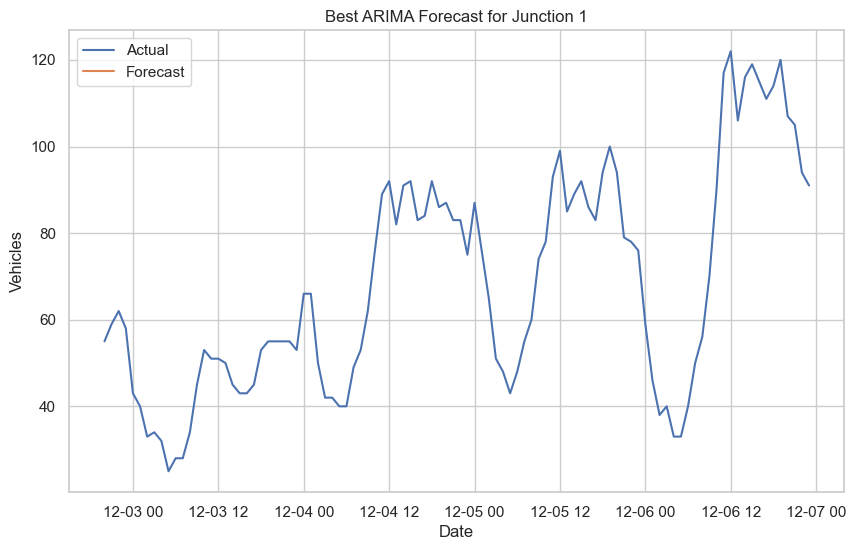

Best ARIMA RMSE: 23.349917699799303


In [87]:
#Step 4: Forecast and Plot
# Ensure the data is sorted by DateTime
df3 = df3.sort_index()

#Select data for Junction 1
junction_1_data = df3[df3['Junction'] == 1]

#Use auto_arima to find the best parameters
auto_model = pm.auto_arima(junction_1_data['Vehicles'], seasonal=False, stepwise=True, suppress_warnings=True)
print(auto_model.summary())

#Fit the best model
best_model = ARIMA(junction_1_data['Vehicles'], order=auto_model.order)
best_model_fit = best_model.fit()

#Forecast the next 24 hours
forecast_steps = 24
best_forecast = best_model_fit.forecast(steps=forecast_steps)

#Create a new dataframe for plotting
forecast_index = pd.date_range(start=junction_1_data.index[-1] + pd.Timedelta(hours=1), periods=forecast_steps, freq='H')
forecast_df = pd.DataFrame(best_forecast, index=forecast_index, columns=['Forecast'])

#Plot the actual and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(junction_1_data.index[-100:], junction_1_data['Vehicles'].iloc[-100:], label='Actual')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast')
plt.title('Best ARIMA Forecast for Junction 1')
plt.xlabel('Date')
plt.ylabel('Vehicles')
plt.legend()
plt.show()

#Calculate RMSE using the last available actual data
actual = junction_1_data['Vehicles'].iloc[-forecast_steps:]
predicted = best_forecast[:len(actual)]
best_rmse = np.sqrt(mean_squared_error(actual, predicted))
print('Best ARIMA RMSE:', best_rmse)

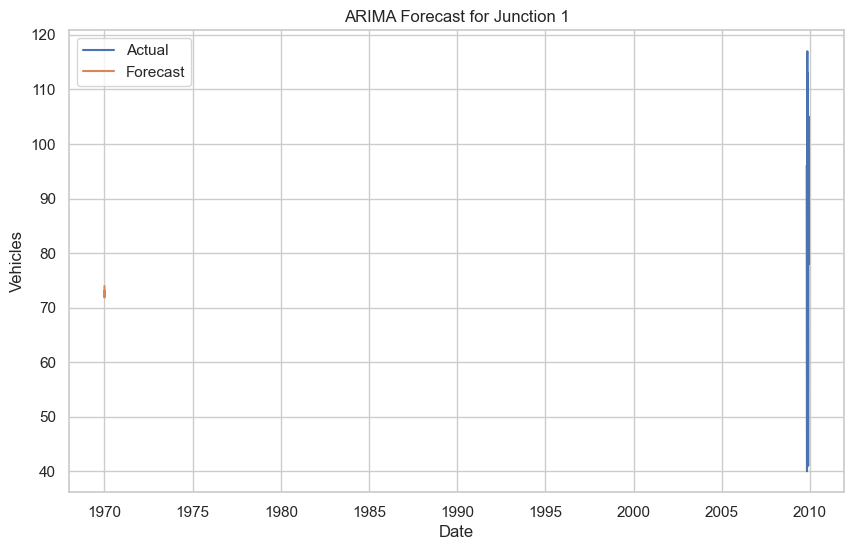

ARIMA RMSE for Junction 1: 5.973951226324065


C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


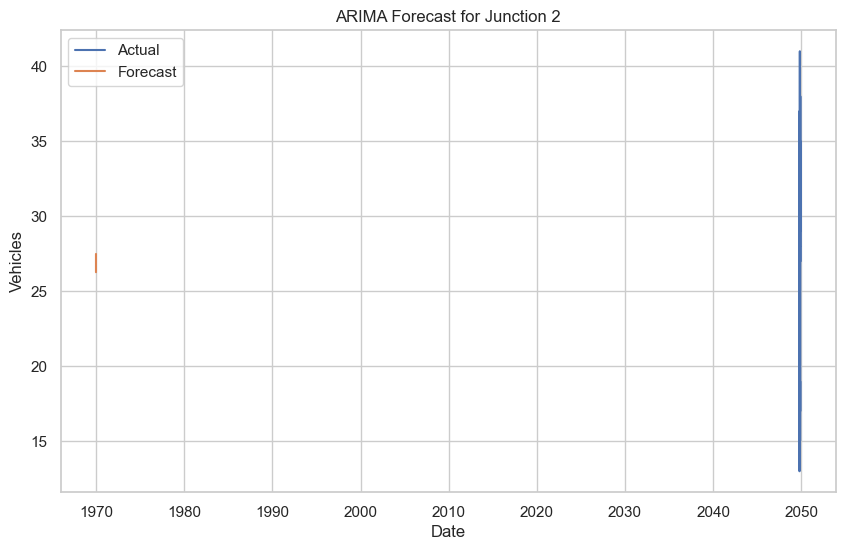

ARIMA RMSE for Junction 2: 2.8258580725510196


C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


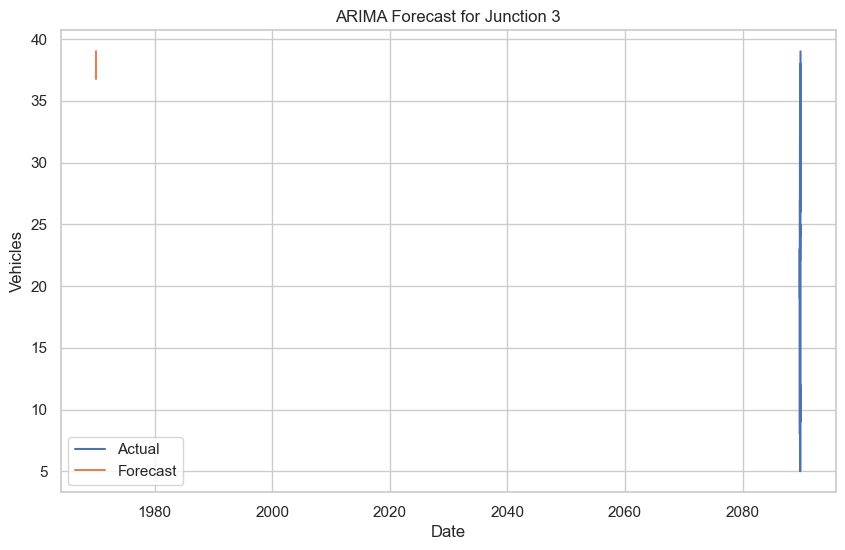

ARIMA RMSE for Junction 3: 5.789275927326549


C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


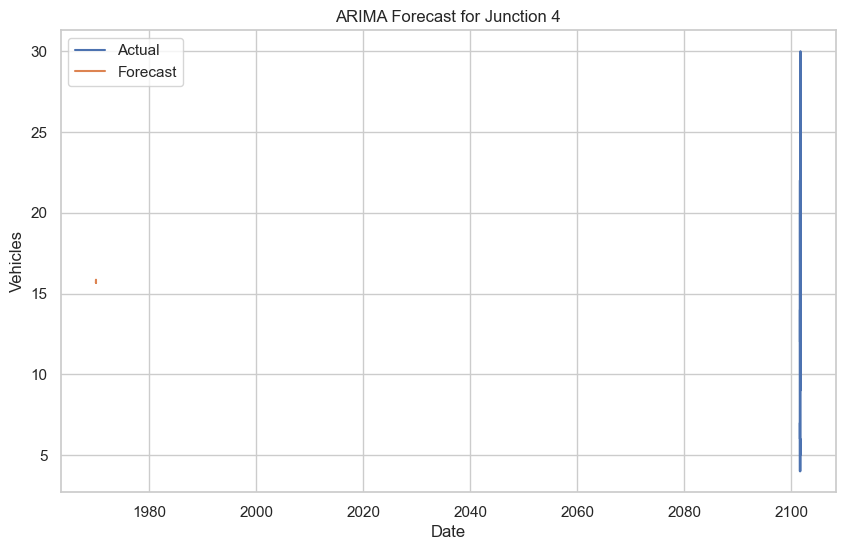

ARIMA RMSE for Junction 4: 2.7746879571443546


In [103]:
#Fit ARIMA model for each junction
junctions = df['Junction'].unique()

for junction in junctions:
    #Subset data for current junction
    df_junction = df[df['Junction'] == junction]
    
    #Fit ARIMA model
    model = ARIMA(df_junction['Vehicles'], order=(5, 1, 0))  
    model_fit = model.fit()
    
    #Forecast next steps
    forecast_steps = 24  # Example: Forecast next 24 hours
    forecast = model_fit.forecast(steps=forecast_steps)
    
    #Plotting 
    plt.figure(figsize=(10, 6))
    plt.plot(df_junction.index[-50:], df_junction['Vehicles'].tail(50), label='Actual')
    plt.plot(pd.date_range(start=df_junction.index[-1], periods=forecast_steps, freq='H'), forecast, label='Forecast')
    plt.title(f'ARIMA Forecast for Junction {junction}')
    plt.xlabel('Date')
    plt.ylabel('Vehicles')
    plt.legend()
    plt.show()
    
    #Evaluate model performance (example using RMSE)
    predictions = model_fit.predict()
    rmse = np.sqrt(mean_squared_error(df_junction['Vehicles'], predictions))
    print(f"ARIMA RMSE for Junction {junction}: {rmse}")

ARIMA RMSE: 16.1495938563007


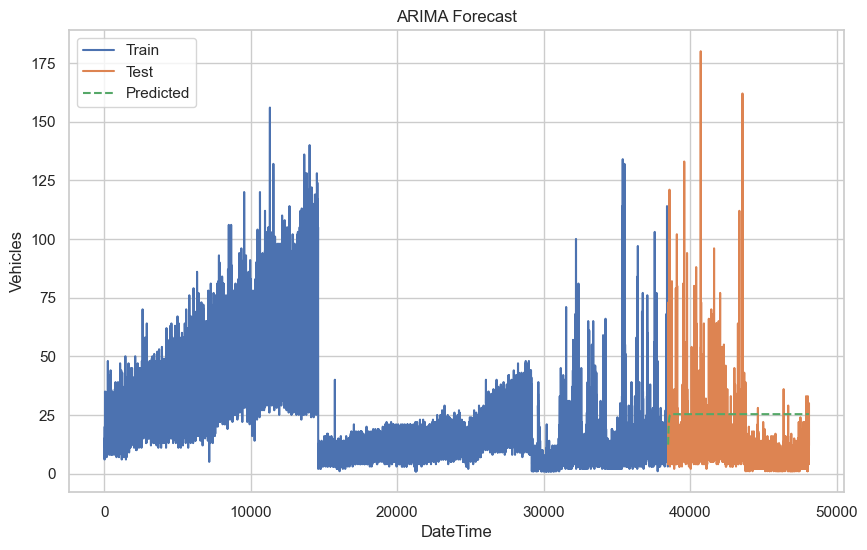

In [123]:
#Training Model
#Split data into training and testing sets
train_size = int(len(df) * 0.8) 
train, test = df[:train_size], df[train_size:]

#fit ARIMA model
model = ARIMA(train['Vehicles'], order=(1, 0, 0))  
arima_model = model.fit()

#Predict on test set
y_pred = arima_model.predict(start=test.index[0], end=test.index[-1], typ='levels')

#Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Vehicles'], y_pred))
print(f"ARIMA RMSE: {rmse}")

#Plot actual vs. predicted
plt.figure(figsize=(10, 6))
plt.plot(train['Vehicles'], label='Train')
plt.plot(test['Vehicles'], label='Test')
plt.plot(y_pred, label='Predicted', linestyle='--')
plt.xlabel('DateTime')
plt.ylabel('Vehicles')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()